In [ ]:
from keras.applications import VGG16
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import Model
from sklearn.metrics.pairwise import euclidean_distances
import cv2

%matplotlib inline

# 1. Loading data, extracting features and saving output as csv file

Initialize the VGG16 Model with the ImageNet weights.  We include the top layer as well!

In [ ]:
# load VGG16
# Get back the convolutional part of a VGG network trained on ImageNet
model = VGG16(weights='imagenet', include_top=True)

In [ ]:
model.summary()

Model that extracts the 4096 output features from the fully connected layer 1 (fc1)

In [ ]:
model_fc1 = Model(input=model.input, output=model.get_layer('fc1').output) # gets the output in fc1
# model_fc1 = Model(input=model.input, output=model.get_layer('flatten').output) # gets the output in flatten

In [ ]:
model_fc1.summary()

Helper function which reads an image.  It resizes the image to 224 x 224 x 3 and preprocess the image.

In [ ]:
def image_pre_process(img_file):
    img = cv2.imread(img_file)

    # resizes the image
    img = resize(img, (224, 224), preserve_range=True).astype(np.float32)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

Function that extracts the list of images, preprocesses the image, extracts the 4096 features and saves in a list.

In [ ]:
def process(retina_list,loc,disease):
    out1=[]
    for i in range(len(retina_list)):#range(8616):
        print(i)
        name = loc + retina_list[i]
        if name[-4:]=='jpeg':
            im = image_pre_process(name)
            
            # fc1
            out = model_fc1.predict(im)
            out = list(out[0])
            out.append(retina_list[i])
            out.append(disease)
            out1.append(out)
                        
    return out1

Gets the list of images from the 4 folders on the Testing Set.

In [ ]:
output_fc1_test=[]

retina_list = !ls OCT2017\ /test/CNV
fc1 = process(retina_list,'OCT2017 /test/CNV/','CNV')
output_fc1_test.append(fc1)

retina_list = !ls OCT2017\ /test/DME
fc1 = process(retina_list,'OCT2017 /test/DME/','DME')
output_fc1_test.append(fc1)

retina_list = !ls OCT2017\ /test/DRUSEN
fc1 = process(retina_list,'OCT2017 /test/DRUSEN/','DRUSEN')
output_fc1_test.append(fc1)

retina_list = !ls OCT2017\ /test/NORMAL
fc1 = process(retina_list,'OCT2017 /test/NORMAL/','NORMAL')
output_fc1_test.append(fc1)

Gets the list of images from the 4 folders on the Training Set.

In [ ]:
output_fc1_train=[]

retina_list = !ls OCT2017\ /train/CNV
fc1 = process(retina_list,'OCT2017 /train/CNV/','CNV')
output_fc1_train.append(fc1)

retina_list = !ls OCT2017\ /train/DME
fc1 = process(retina_list,'OCT2017 /train/DME/','DME')
output_fc1_train.append(fc1)

retina_list = !ls OCT2017\ /train/DRUSEN
fc1 = process(retina_list,'OCT2017 /train/DRUSEN/','DRUSEN')
output_fc1_train.append(fc1)

retina_list = !ls OCT2017\ /train/NORMAL
fc1 = process(retina_list,'OCT2017 /train/NORMAL/','NORMAL')
output_fc1_train.append(fc1)

Function that flattens the list, converts to a Pandas DataFrame and saves as a csv file.

In [ ]:
def flatten_save(output_fc1, filename):
    newlist_fc1 = [item for items in output_fc1 for item in items]
    print('The data set has',len(newlist_fc1),'rows.')
    res_fc1 = pd.DataFrame(newlist_fc1)
    print(res_fc1.sample(2))
    res_fc1.to_csv(filename)

Saves the test csv file.

In [ ]:
flatten_save(output_fc1_test, 'Features_Test_fc1.csv')

Saves the train csv file

In [ ]:
flatten_save(output_fc1_train, 'Features_Train_fc1.csv')

# 2. Load data from csv file, balance the number of sample, apply dimensionality reduction and build Random Forest Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Load train data

In [2]:
res_train = pd.read_csv('Features_Train_fc1.csv')

The data is biased, so we will downsample to get an even number of samples per class.

8616


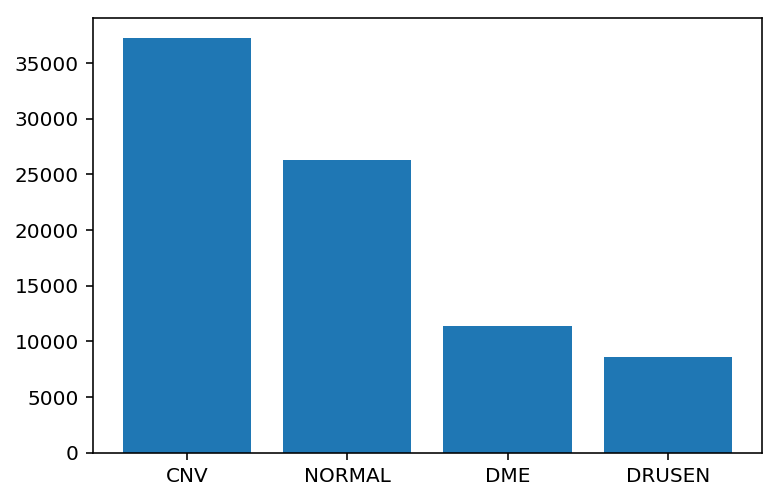

In [3]:
def data_hist(df):
    vals = df.iloc[:,-1].value_counts().values
    ind = df.iloc[:,-1].value_counts().index
    plt.bar(range(len(ind)),vals,tick_label = ind)
    return min(vals)
min_sample = data_hist(res_train)
print(min_sample)

We will only get the first 8616 samples from each group.

8616

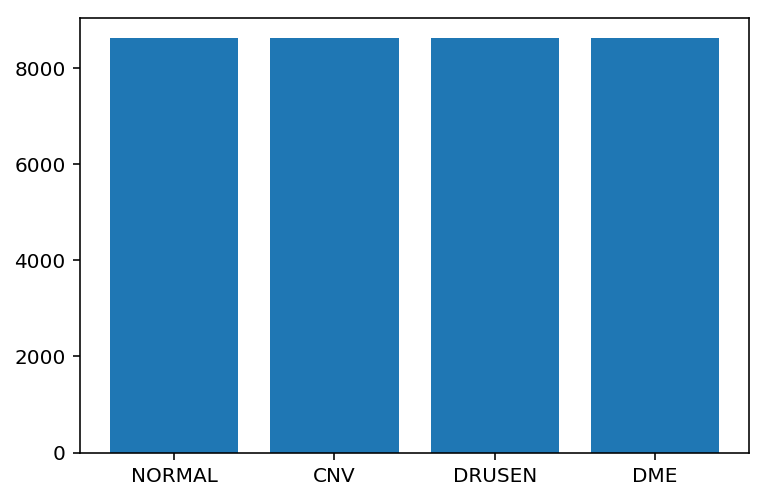

In [4]:
res2 = res_train[res_train.iloc[:,-1]=='CNV'].iloc[:min_sample]
res2 = pd.concat([res2,res_train[res_train.iloc[:,-1]=='NORMAL'].iloc[:min_sample]])
res2 = pd.concat([res2,res_train[res_train.iloc[:,-1]=='DME'].iloc[:min_sample]])
res2 = pd.concat([res2,res_train[res_train.iloc[:,-1]=='DRUSEN'].iloc[:min_sample]])
res = res2
data_hist(res)

Separate the X and y

In [5]:
def separate_XY(res):
    X = res.copy()
    X.drop(['Unnamed: 0','4096','4097'],axis=1, inplace=True)
#     X.drop(['Unnamed: 0','25088','25089'],axis=1, inplace=True)
    y = res.iloc[:,-1].copy()
    print(y.value_counts())
    return X, y

X_train, y_train = separate_XY(res)

NORMAL    8616
CNV       8616
DRUSEN    8616
DME       8616
Name: 4097, dtype: int64


Loads the test data

In [6]:
res = pd.read_csv('Features_Test_fc1.csv')

242

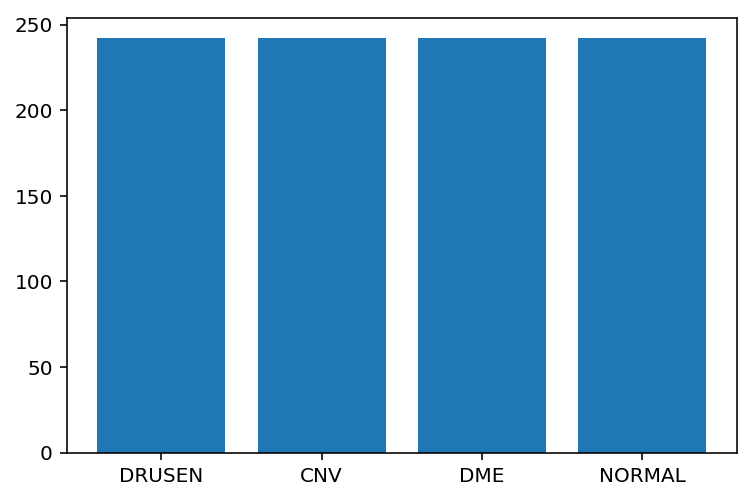

In [7]:
data_hist(res)

In [8]:
X_test, y_test = separate_XY(res)

DRUSEN    242
CNV       242
DME       242
NORMAL    242
Name: 4097, dtype: int64


### Dimensionality Reduction

In [9]:
n_components=200
pca_model = PCA(n_components=n_components)
X_train = pca_model.fit_transform(X_train)
X_test = pca_model.transform(X_test)

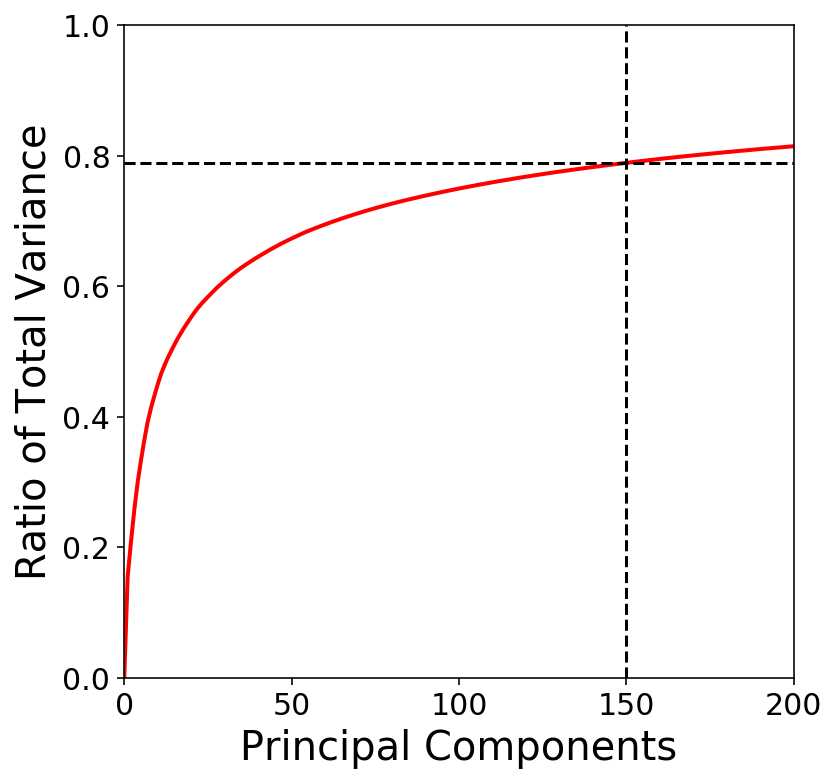

In [10]:
PCA_var = pca_model.explained_variance_ratio_
PCA_var=np.insert(PCA_var,0,0)
PCA_var_cumsum = np.cumsum(PCA_var)

loc = 150
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize=[6,6])
plt.plot(PCA_var_cumsum,'r',linewidth=2)
plt.plot([loc,loc],[0,1],'k--')
plt.plot([0,n_components],[PCA_var_cumsum[loc],PCA_var_cumsum[loc]],'k--')
plt.axis([0,n_components,0,1])
plt.xlabel('Principal Components',fontsize=20)
plt.ylabel('Ratio of Total Variance',fontsize=20)
plt.savefig('PCA.jpg')

In [11]:
print('Variance with 150 PCs :',PCA_var_cumsum[150])

Variance with 150 PCs : 0.789177909224634


Apply PCA on both the train and test set using 150 components.

In [12]:
n_components=150
pca_model = PCA(n_components=n_components)
X_train = pca_model.fit_transform(X_train)
X_test = pca_model.transform(X_test)

### Building Random Forest Classifier

In [13]:
# rf = RandomForestClassifier(max_depth = 25, n_estimators = 500,random_state=42)
rf = RandomForestClassifier(n_estimators = 500,random_state=42)

rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9493801652892562


In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
}

In [ ]:
# Create a based model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)

In [ ]:
grid_accuracy = accuracy_score(y_test, y_pred)
print(grid_accuracy)